In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering, plot_dendrogram
from tasks.running_example import make_task
shap.initjs()

In [2]:
feature_precisions = [2, 2]

In [3]:
with open('shap.expl', 'rb') as f:
    explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = \
        pickle.load(f)

In [4]:
clf_a, clf_b, X, y, feature_names = make_task()

In [5]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [7]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 601it [00:38, 15.78it/s]                          


CPU times: user 37.4 s, sys: 1.41 s, total: 38.8 s
Wall time: 49.4 s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [5]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((600, 2), (0,), (0,))

In [19]:
xlim = explanations.data[:, 0].min() - 0.5, explanations.data[:, 0].max() + 0.5
ylim = explanations.data[:, 1].min() - 0.5, explanations.data[:, 1].max() + 0.5

# Traditional SHAP Explanations

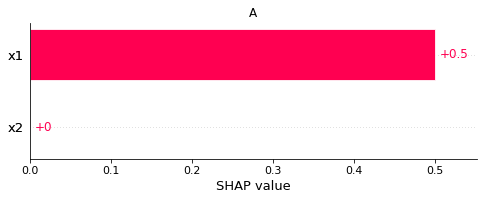

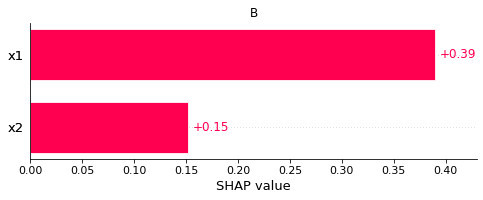

In [3]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [4]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])

In [5]:
node, Z = make_clustering(comparer, explanations.indiv.labels[:, :, 1])

root
(0, 0)    266
(1, 1)    236
(1, 0)     64
(0, 1)     34
dtype: int64


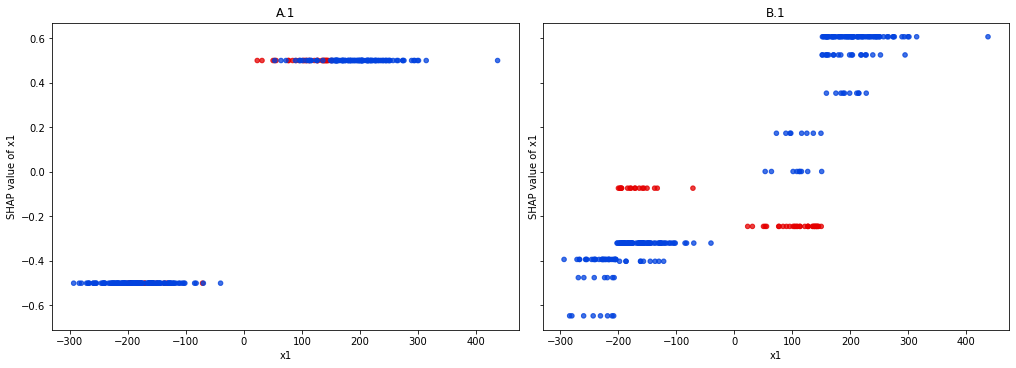

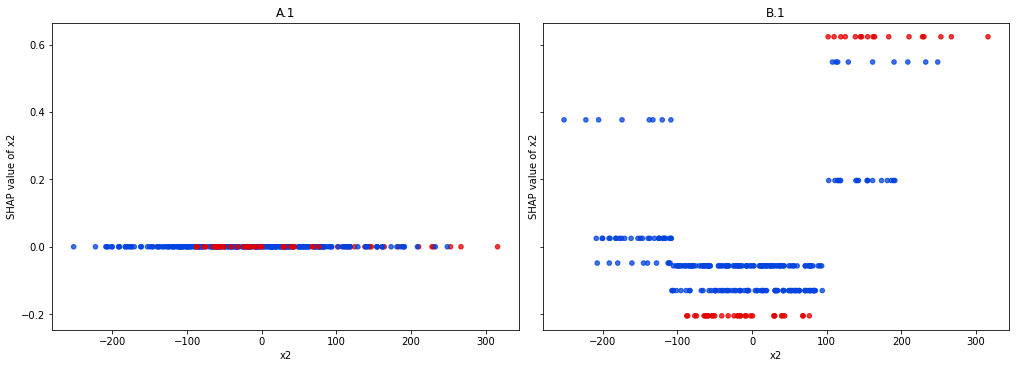

In [7]:
for feature in feature_order:
    node.plot_feature(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

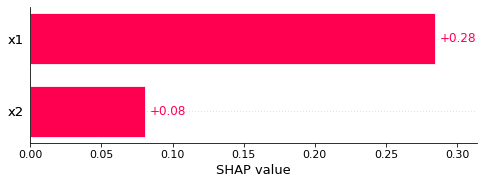

In [6]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(feature_importances)

In [7]:
global_feature_order = feature_order

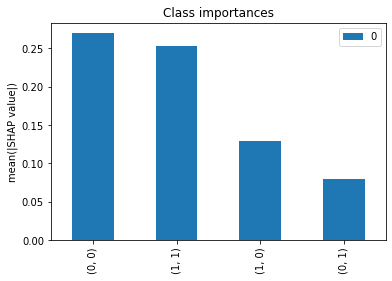

In [8]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [9]:
node, Z = make_clustering(comparer, explanations.mclass_diff.labels,
                          '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                          feature_precisions=feature_precisions)

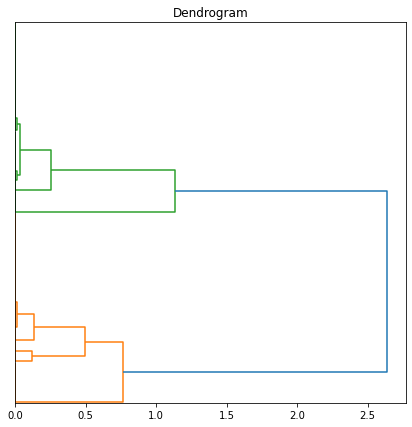

In [10]:
plot_dendrogram(Z)

### Node RL

In [11]:
node.class_counts, node.distance

((0, 0)    266
 (1, 1)    236
 (1, 0)     64
 (0, 1)     34
 dtype: int64,
 2.637883333333333)

In [12]:
node = node.get_right()
node.class_counts, node.distance

((0, 0)    266
 (0, 1)     34
 dtype: int64,
 1.1312166666666665)

In [14]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    34
 dtype: int64,
 0.0)

We've certainly reached the lowest layer, because the distance is 0.

-199.69916519629095 <= x1 <= -71.25341441967325
x1 <= -203.78 --> {'(0, 0)': 34}
x1 >= -8.54 --> {'(1, 1)': 34}


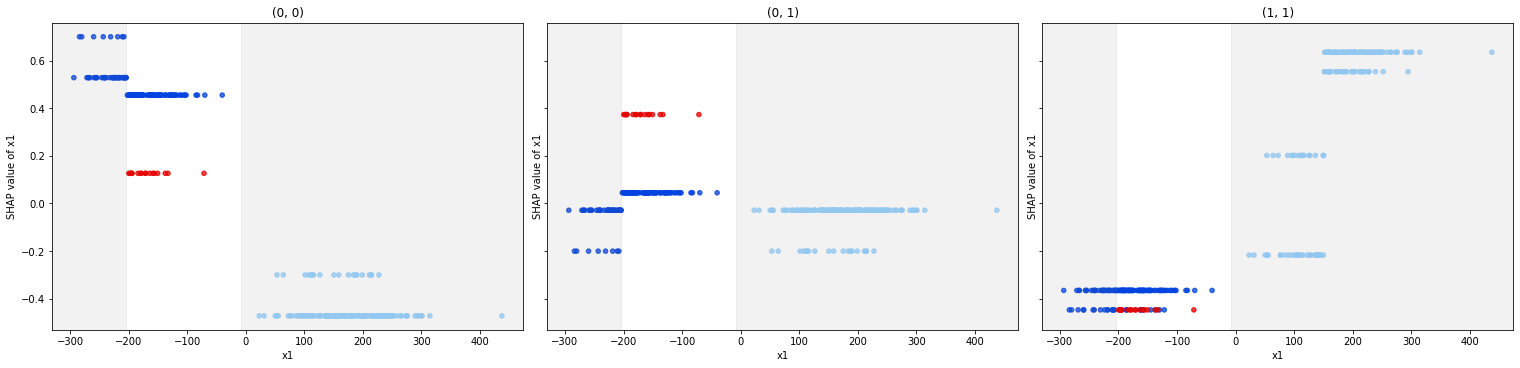

101.87170468931079 <= x2
x2 <= 97.53 --> {'(0, 0)': 34}


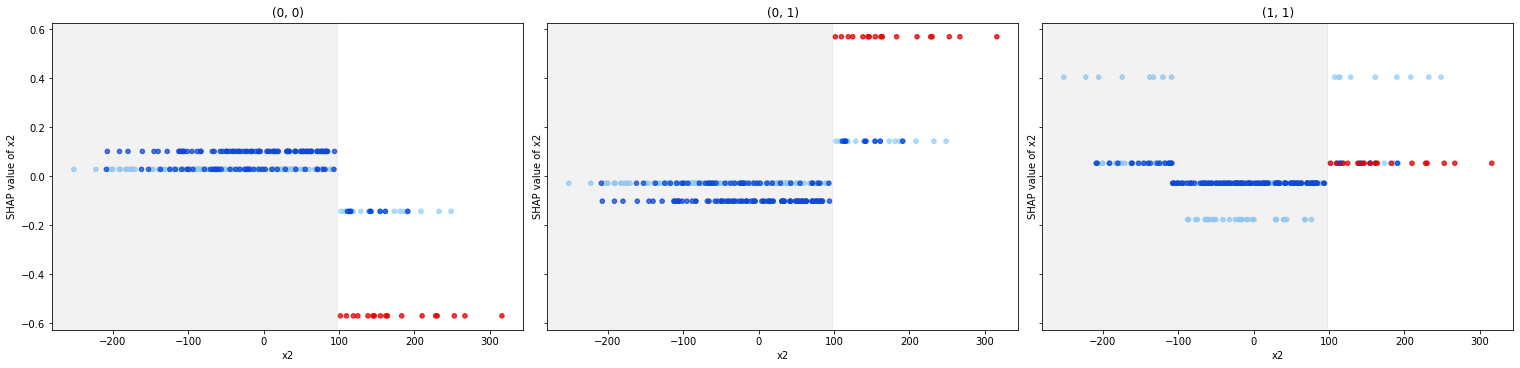

In [17]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node.parent, alpha=0.5)

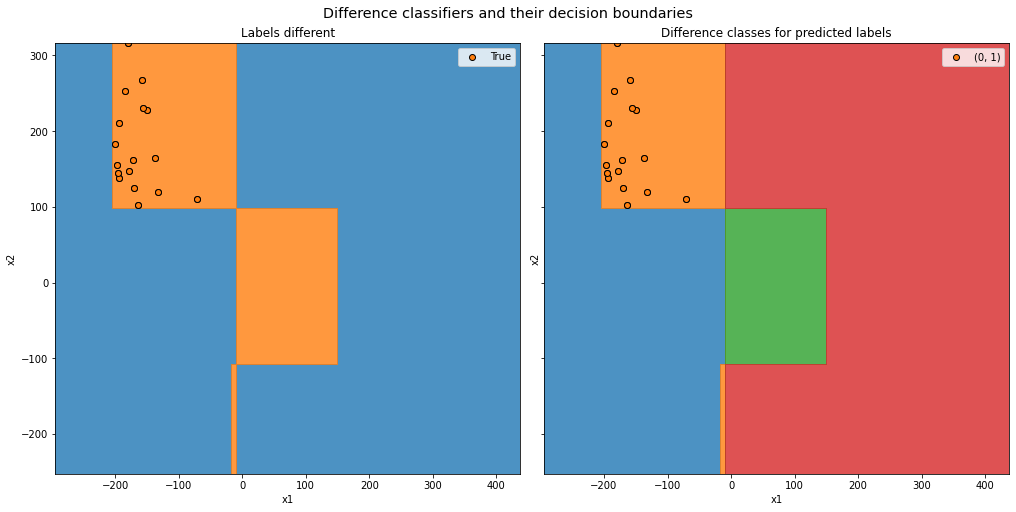

In [20]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

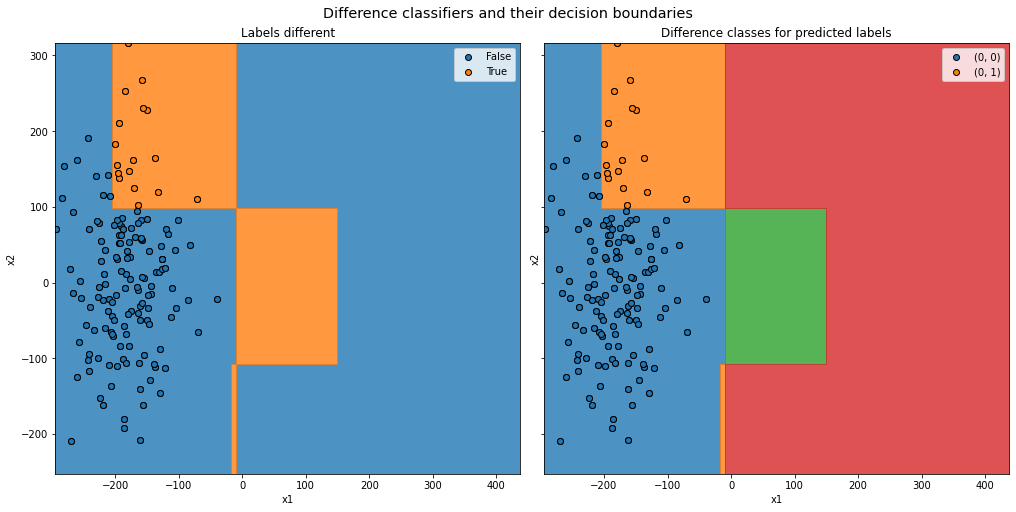

In [21]:
comparer.plot_decision_boundaries(node.parent.shap_values.data, xlim=xlim, ylim=ylim)

## Clustering of Class $(1,0)$ SHAP Values

In [22]:
node, Z = make_clustering(comparer, explanations.mclass_diff.labels,
                          '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'],
                          feature_precisions=feature_precisions)

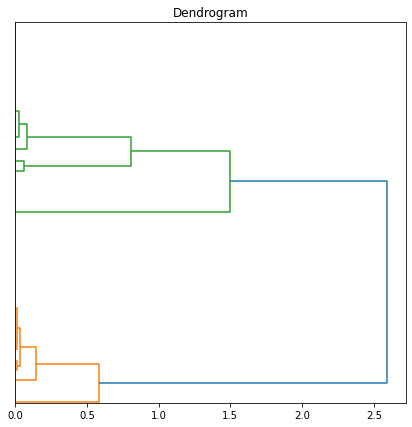

In [23]:
plot_dendrogram(Z)

### Node RL

In [24]:
node.class_counts, node.distance

((0, 0)    266
 (1, 1)    236
 (1, 0)     64
 (0, 1)     34
 dtype: int64,
 2.5922833333333326)

In [25]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    236
 (1, 0)     64
 dtype: int64,
 1.494677777777778)

In [26]:
node = node.get_left()
node.class_counts, node.distance

((1, 0)    64
 dtype: int64,
 0.0)

23.067264476014415 <= x1 <= 149.93548780588142
x1 <= -8.55 --> {'(0, 0)': 64}
x1 >= 150.75 --> {'(1, 1)': 64}


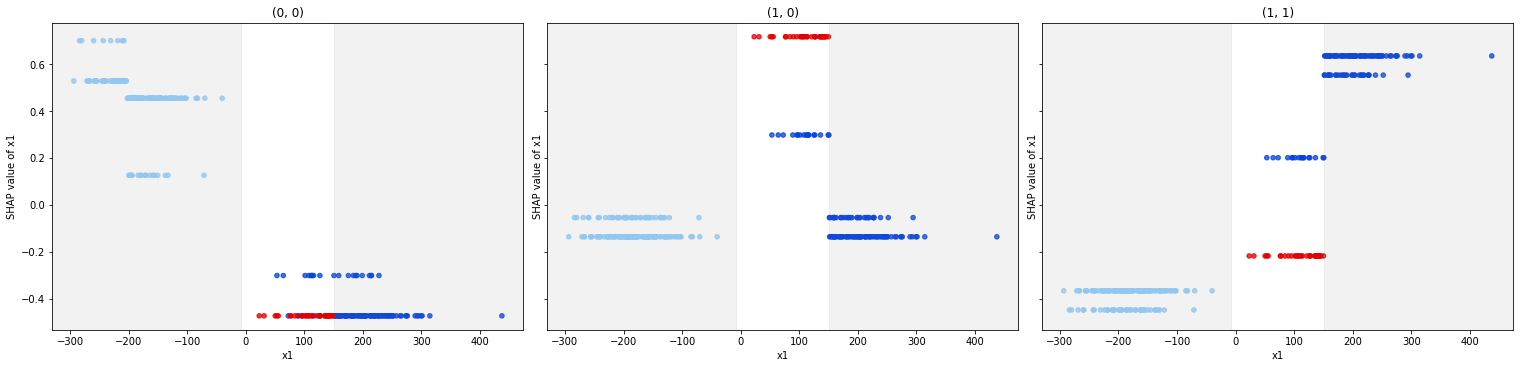

-87.58963700149516 <= x2 <= 76.76250825051287
x2 <= -108.16 --> {'(1, 1)': 64}
x2 >= 97.54 --> {'(1, 1)': 64}


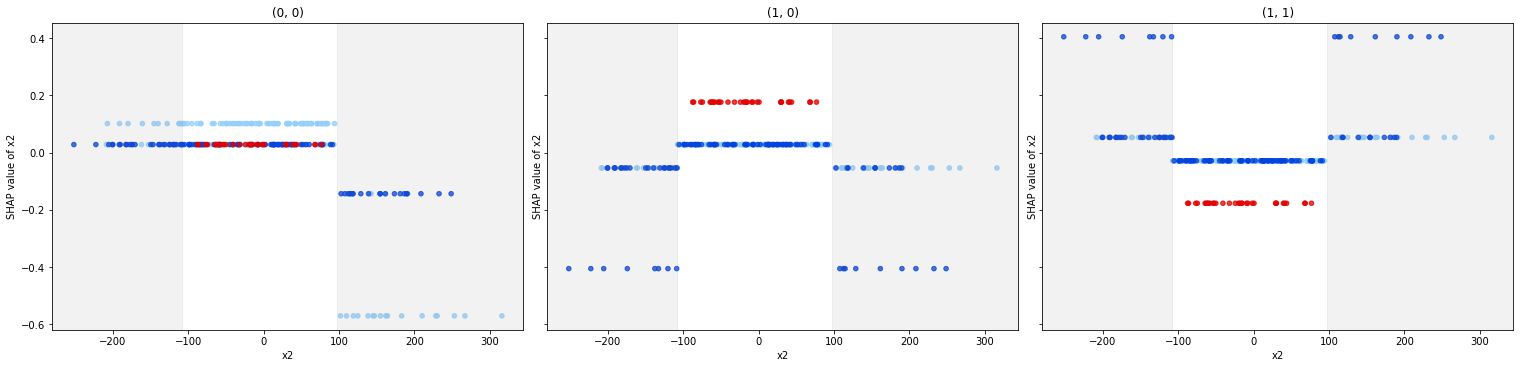

In [28]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node.parent, alpha=0.5)

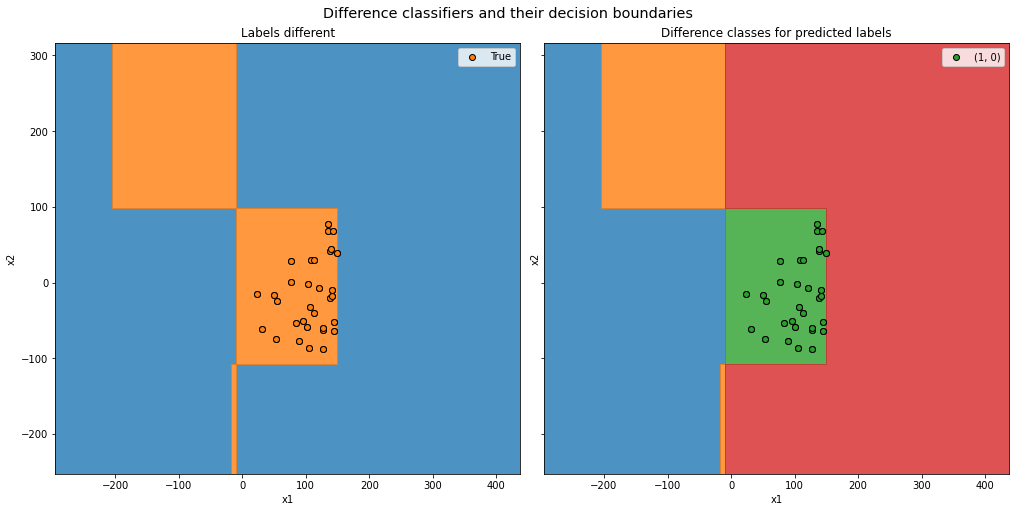

In [29]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

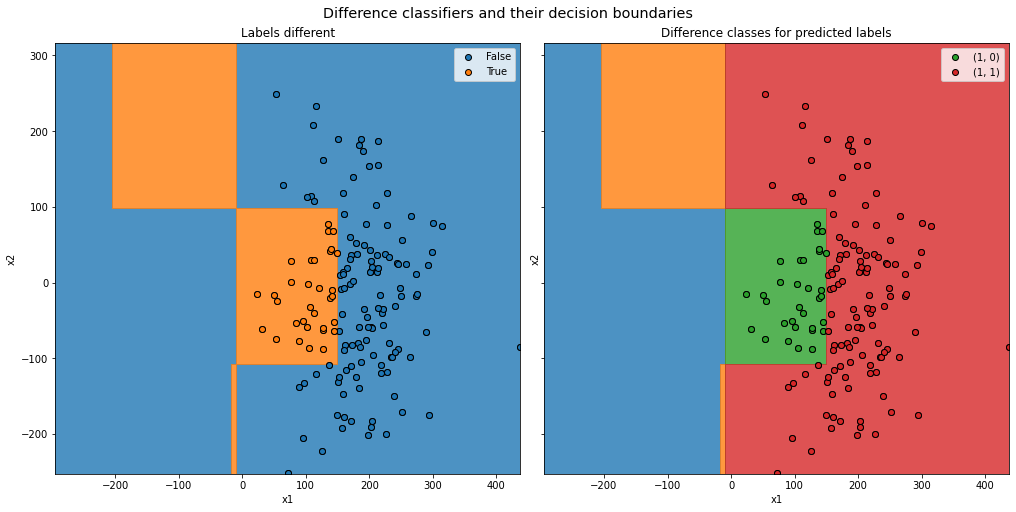

In [30]:
comparer.plot_decision_boundaries(node.parent.shap_values.data, xlim=xlim, ylim=ylim)

# Explanations
- rule 1 ($(0,1)$/node RL): $-203.8 < x1 < -8.5, 97.5 < x2 \rightarrow (0,1)$
- rule 2 ($(1,0)$/node RL): $-8.6 < x1 < 150.8, -108.2 < x2 < 97.6 \rightarrow (1,0)$

Details:

$(0,1)$:
- Differences: $-199.7 < x1 < -71.2, 101.8 < x2$ (34 instances)
- R: $x1 < -40.2$
    - CF: $x1≥-8.5 \rightarrow (1,1)$
    - RL: $x1 > -199.7, x2 > 101.8$
        - CF: $x1≤-203.8 \rightarrow (0,0)$
        - CF: $x2≤97.5 \rightarrow (0,0)$

$(1,0)$:
- Differences: $-23.1 < x1 < 150.0, -87.6 < x2 < 76.8$ (64 instances)
- R: $x1 > 23.0$
    - CF: $x1≤-8.6 \rightarrow (0,0)$
    - RL: $x1 < 150.0, -87.6 < x2 < 76.8$
        - CF: $x1≥150.8 \rightarrow (1,1)$
        - CF: $x2≤-108.2 \rightarrow (1,1)$
        - CF: $x2≥97.6 \rightarrow (1,1)$

# Evaluation

## Fidelity
- difference 1 (rule 1): no error
- difference 2 (rule 2): no error

## Predictability
The explanation only generalizes to differences #1 and #2.


## Selectiveness
Best possible (minimal set of rules to describe the differences detected)

## Persuability
Like the surrogate decision tree approach, this method suffers from the incompleteness of the data set, which is why it didn't detect difference 3.